# 3-3. Chambolle-Pock
CT image reconstruction

In [1]:
''' import '''
import scipy.io as io
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt

In [2]:
''' load data '''
data = io.loadmat('./data/hw3_prob3.mat')

A = data['A']               # (30720, 65536)
b = data['b']               # (30720, 1)
x_orig = data['x_orig']     # (256, 256)

M, N = x_orig.shape
K, _ = b.shape

In [ ]:
''' TV '''
def D_h(x):
    return np.roll(x, -1, axis=0) - x
def D_h_T(x):
    return np.roll(x, 1, axis=0) - x

def D_v(x):
    return np.roll(x, -1, axis=1) - x
def D_v_T(x):
    return np.roll(x, 1, axis=1) - x

In [ ]:
''' hyper param '''
MU = 1
LAMBDA = 0.0002
MAXITERS = 500
CRIT = 5e-4

L = sla.norm(A, ord=2)**2 # sigma*tau*L^2 <= 1, sigma*tau < 1/L^2

In [ ]:
''' function '''
def trunc(z, t):
    return np.sign(z)*np.minimum(np.abs(z), t)

In [ ]:
''' TV (D_h, D_v) '''
Im = sp.eye(M)
Dn = sp.diags([1, -1, 1], offsets=(-(N-1), 0, 1), shape=(N,N))
D_h = sp.kron(Im, Dn)

In = sp.eye(N)
Dm = sp.diags([1, -1, 1], offsets=(-(M-1), 0, 1), shape=(M,M))
D_v = sp.kron(Dm, In)

In [ ]:
''' Chambolle-Pock '''

MAXITERS = 300
CRIT = 1e-7
tau = 1/L
sigma = 1/L
theta = 1 / np.sqrt(1 + 2*MU*tau) # tau는 왜?

fn_cham = []
xn_cham = []

x = np.ones((M*N, 1))
# x = x_orig.reshape(-1,1)
x_prev = x

y1 = np.zeros((K, 1))
y2 = np.zeros((M*N, 1))
y3 = np.zeros((M*N, 1))

for k in range(MAXITERS):

    # f
    fn = (MU/2)*la.norm(A@x - b)**2 + LAMBDA*la.norm(D_h@x, 1) + LAMBDA*la.norm(D_v@x, 1)

    # update
    y1 = ((y1 - sigma*(A@x)) + sigma*MU*b) / (1 + sigma*MU)
    y2 = trunc(y2 + sigma*D_h@x, sigma)
    y3 = trunc(y3 + sigma*D_v@x, sigma)

    x = np.maximum(x - tau*(A.T@y1 + D_h.T@y2 + D_v.T@y3), 0)

    theta = 1 / np.sqrt(1 + 2*MU*tau)
    tau = theta*tau
    sigma = sigma/theta
    
    if (k >= 1):
        x = x + theta*(x - x_prev)
    
    # stop condition
    xcon = la.norm(x - x_prev)/la.norm(x)
    if (k >= 1) and (la.norm(x - x_prev)/la.norm(x) < CRIT):
        break
    
    x_prev = x

    # history
    fn_cham.append(fn)
    xn_cham.append(xcon)
    print(f'i = {k:<4d}, |x-x|/|x| = {xcon:.8f}, σ = {sigma:.5f}, τ = {tau:.5f}, f = {fn:.0f}')
    # print(f'i = {k:<4d}, {sigma}, {tau}, f = {fn:.0f}')

# optimal
x_cham = x

i = 0   , |x-x|/|x| = 0.00512063, σ = 0.00004, τ = 0.00004, f = 16989329057516
i = 1   , |x-x|/|x| = 0.02089345, σ = 0.00004, τ = 0.00004, f = 16990481998588
i = 2   , |x-x|/|x| = 0.03231312, σ = 0.00004, τ = 0.00004, f = 16995094018364
i = 3   , |x-x|/|x| = 0.04493934, σ = 0.00004, τ = 0.00004, f = 17002013476332
i = 4   , |x-x|/|x| = 0.05935468, σ = 0.00004, τ = 0.00004, f = 17011242280607
i = 5   , |x-x|/|x| = 0.07638034, σ = 0.00004, τ = 0.00004, f = 17022783035063
i = 6   , |x-x|/|x| = 0.09723869, σ = 0.00004, τ = 0.00004, f = 17036639040027
i = 7   , |x-x|/|x| = 0.12384356, σ = 0.00004, τ = 0.00004, f = 17052814293178
i = 8   , |x-x|/|x| = 0.15932952, σ = 0.00004, τ = 0.00004, f = 17071313490668
i = 9   , |x-x|/|x| = 0.20896690, σ = 0.00004, τ = 0.00004, f = 17092142028453
i = 10  , |x-x|/|x| = 0.28114364, σ = 0.00004, τ = 0.00004, f = 17115306003835
i = 11  , |x-x|/|x| = 0.37779624, σ = 0.00004, τ = 0.00004, f = 17140812217226
i = 12  , |x-x|/|x| = 0.44077842, σ = 0.00004, τ = 0

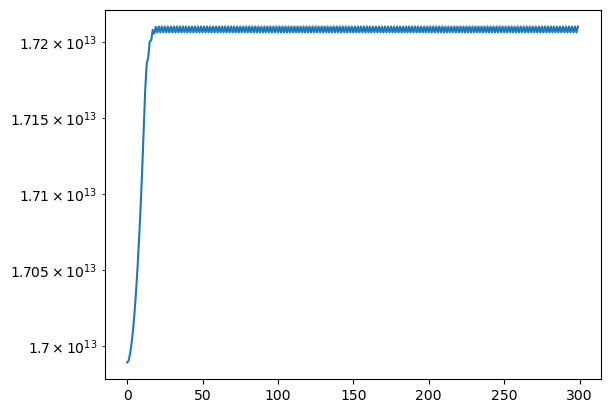

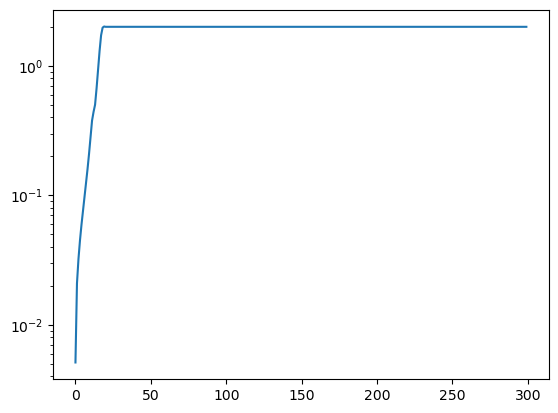

In [ ]:
plt.semilogy(fn_cham)
plt.show()

plt.semilogy(xn_cham)
plt.show()

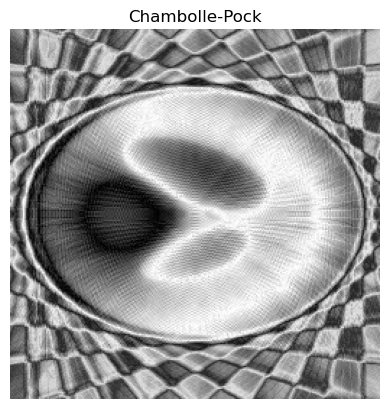

In [ ]:
plt.imshow(x_cham.reshape(M,N), cmap='gray')
plt.title('Chambolle-Pock')
plt.axis('off')
# err = (A@x_cham-b).reshape(120, N)
# plt.imshow(err, cmap='gray')
plt.show()